## Simulation of a CSTR

In [13]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np
import time
import cantera as ct

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [14]:
# Import modules and set plotting defaults
%matplotlib notebook
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True

In [15]:
# Define the gas
gas = ct.Solution('gri30.xml')

In [16]:
# Define initial conditions
# Inlet gas conditions
reactorTemperature = 925  # Kelvin
reactorPressure = 1.046138*ct.one_atm  # in atm. This equals 1.06 bars
concentrations = {'CH4': 0.035, 'O2': 0.0275, 'Ar': 0.9675}
gas.TPX = reactorTemperature, reactorPressure, concentrations 

In [17]:
# Reactor parameters
residenceTime = 2  # s
reactorVolume = 30.5*(1e-2)**3  # m3

In [18]:
# Instrument parameters

# This is the "conductance" of the pressure valve and will determine its efficiency in 
# holding the reactor pressure to the desired conditions. 
pressureValveCoefficient = 0.01

# This parameter will allow you to decide if the valve's conductance is acceptable. If there
# is a pressure rise in the reactor beyond this tolerance, you will get a warning
maxPressureRiseAllowed = 0.01

In [19]:
# Simulation parameters
# Simulation termination criterion
maxSimulationTime = 50  # seconds

In [ ]:
# flow direction
# Mixture tank => Mass flow Controller => Stirred Reactor => Pressure Valve => Capture tank

In [20]:
# Initialize the stirred reactor and connect all peripherals
fuelAirMixtureTank = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)

massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                           downstream=stirredReactor,
                                           mdot=stirredReactor.mass/residenceTime)

pressureRegulator = ct.Valve(upstream=stirredReactor,
                             downstream=exhaust,
                             K=pressureValveCoefficient)

reactorNetwork = ct.ReactorNet([stirredReactor])

In [21]:
# Now compile a list of all variables for which we will store data
columnNames = [stirredReactor.component_name(item) for item in range(stirredReactor.n_vars)]
columnNames = ['pressure'] + columnNames

# Use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=columnNames)

In [22]:
# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < maxSimulationTime:
    t = reactorNetwork.step()

    # We will store only every 10th value. Remember, we have 1200+ species, so there will be
    # 1200 columns for us to work with
    if(counter%10 == 0):
        # Extract the state of the reactor
        state = np.hstack([stirredReactor.thermo.P, stirredReactor.mass, 
                   stirredReactor.volume, stirredReactor.T, stirredReactor.thermo.X])
        
        # Update the dataframe
        timeHistory.loc[t] = state
    
    counter += 1

# Stop the stopwatch
toc = time.time()

print('Simulation Took {:3.2f}s to compute, with {} steps'.format(toc-tic, counter))

Simulation Took 0.12s to compute, with 259 steps


In [23]:
# We now check to see if the pressure rise during the simulation, a.k.a the pressure valve
# was okay
pressureDifferential = timeHistory['pressure'].max()-timeHistory['pressure'].min()
if(abs(pressureDifferential/reactorPressure) > maxPressureRiseAllowed):
    print("WARNING: Non-trivial pressure rise in the reactor. Adjust K value in valve")

<IPython.core.display.Javascript object>


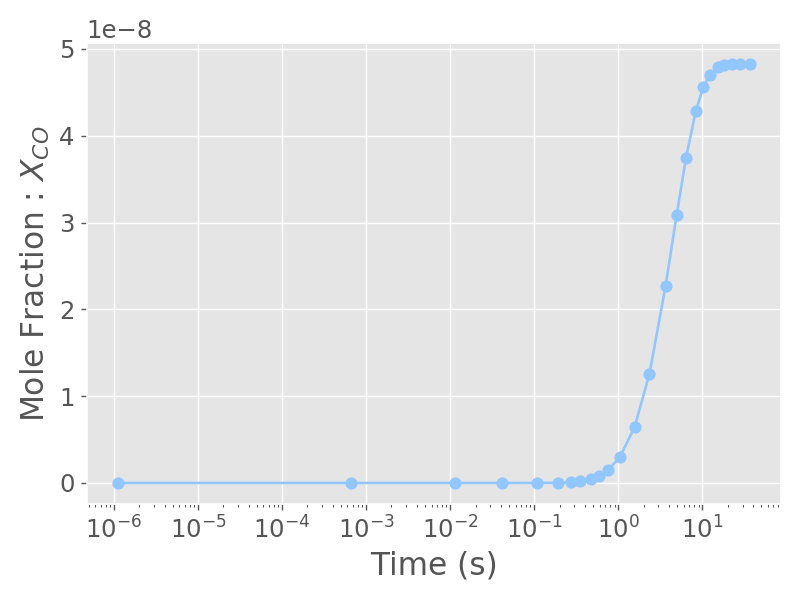

Text(0, 0.5, 'Mole Fraction : $X_{CO}$')

In [24]:
# Plot the results
plt.figure()
plt.semilogx(timeHistory.index, timeHistory['CO'],'-o')
plt.xlabel('Time (s)')
plt.ylabel(r'Mole Fraction : $X_{CO}$')

In [25]:
# https://cantera.org/examples/jupyter/reactors/stirred_reactor.ipynb.html